In [3]:
import tensorflow as tf
import os
from pitchfuncs_ultra_pca import WMSE
from pitchfuncs_ultra_pca import InversePCA
from pitchfuncs_ultra_pca import emulator
from pitchfuncs_ultra_pca import ultra_ns
from pitchfuncs_ultra_pca import ultra_ns_vector
from pitchfuncs_ultra_pca import ultra_ns_vector_nice
from pitchfuncs_ultra_pca import ultra_ns_vector_naughty
import pandas as pd
import scipy
import numpy as np
import corner
import time
from scipy import constants
from scipy import stats
import astropy.constants
import pickle
from matplotlib.pyplot import cm
import json
import matplotlib.pyplot as plt
import ultranest

def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())

os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

print("Current GPU usage:\n"
     + " - GPU0: " + str(gpu0usage) + "B\n")

Current GPU usage:
 - GPU0: 0B



In [4]:
hare = pd.read_json("pickle jar/solar_hare.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

n_min = 6
n_max = 40

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = hare[outputs]

hare

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,star_feh,nu_0_4,...,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std,log_calc_effective_T_std
3806715,0.98,0.013508,0.24,2.1,4.384008,0.938134,0.796204,5633.170928,-0.046555,736.048182,...,0.891185,0.892424,0.893956,0.895084,0.895033,0.896013,0.896049,0.894976,0.892958,-0.378239


In [5]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


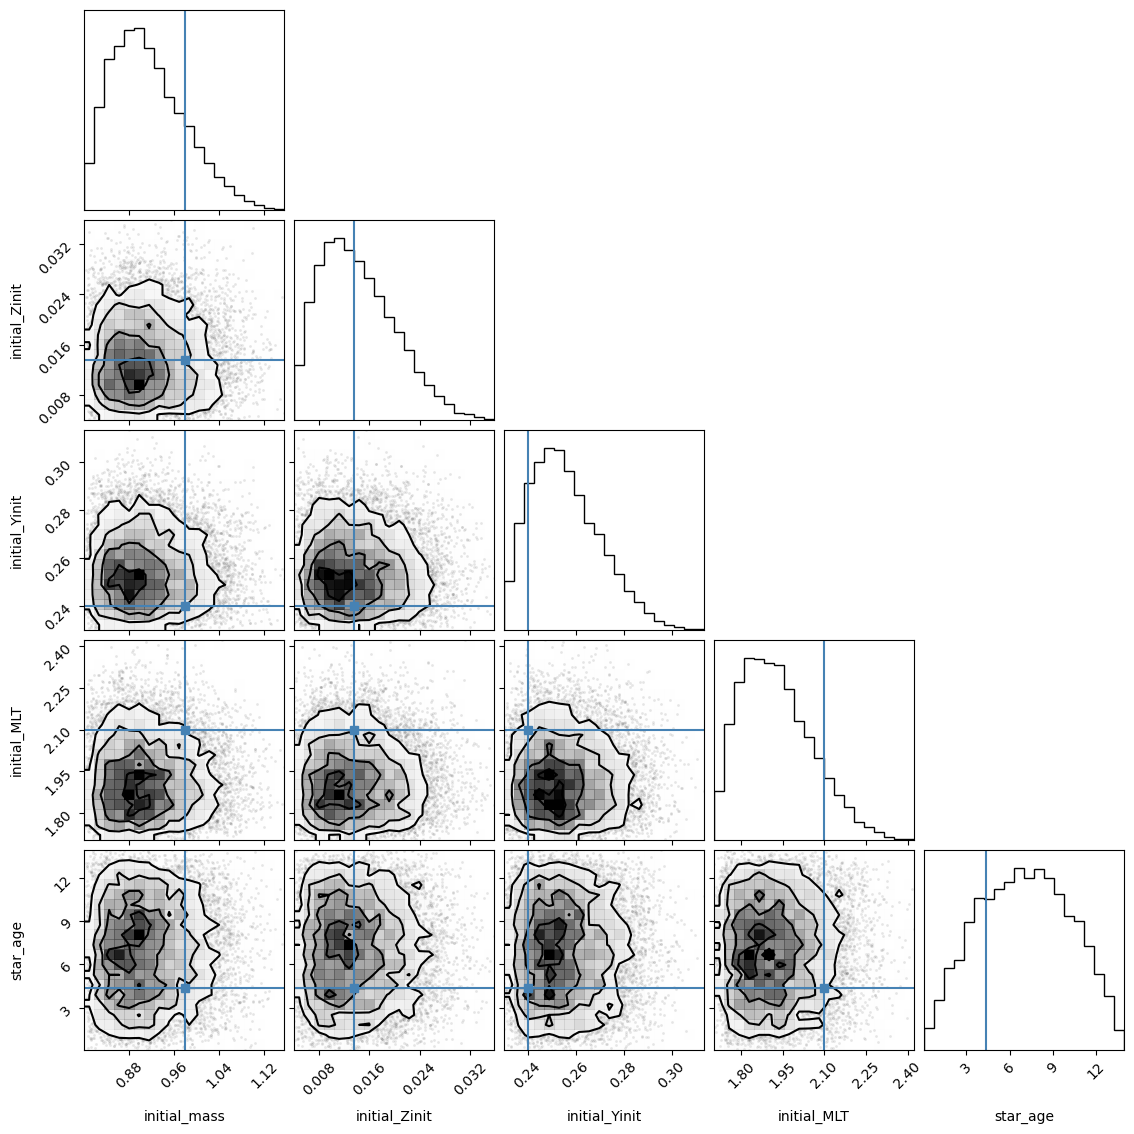

In [6]:
def grid_uniform_prior(pitchfork_ranges, header):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.uniform(loc=grid_min, scale=max(list(pitchfork_ranges["log_"+header].values()))-grid_min)

def grid_beta_prior(pitchfork_ranges, header,a=1,b=1):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.beta(loc=grid_min, scale=grid_max-grid_min, a=a, b=b)

def custom_uniform_prior(prior_min, prior_max):
    return scipy.stats.uniform(loc=prior_min, scale=prior_max-prior_min)

def custom_beta_prior(prior_min, prior_max, a=1, b=1):
    return scipy.stats.beta(loc=prior_min, scale=prior_max-prior_min, a=a, b=b)

mass_prior = custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = custom_beta_prior(0.0038, 0.04, a=2, b=5)

Yinit_prior = custom_beta_prior(0.23, 0.32, a=2, b=5)

MLT_prior = custom_beta_prior(1.7, 2.5, a=2, b=5)

age_prior = custom_beta_prior(0, 14, a=2, b=2)


priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});

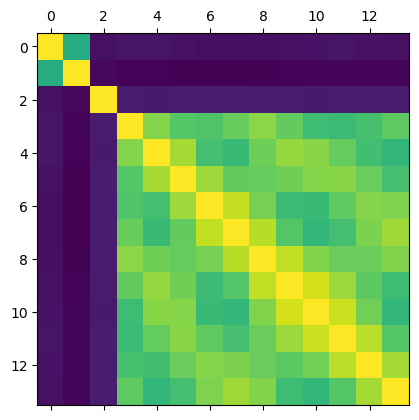

In [14]:
hare = pd.read_json("pickle jar/solar_hare.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

n_min = 15
n_max = 25

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = pitchfork.predict([hare_inps.values[0]], n_min=n_min, n_max=n_max)

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = .1 #\muHz


obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc for i in range(n_min,n_max+1)])

emulator_errors = pd.read_json('pickle jar/emulator_errors2.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,41)]
emulator_errors = emulator_errors[outputs]

corr = np.corrcoef(emulator_errors.to_numpy().T)
plt.matshow(corr)

emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = (obs_unc*obs_unc)*(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

In [ ]:
ndraw_min=2**16
ndraw_max=2**18
sampler = ultra_ns_vector_nice(priors=priors, observed_vals=hare_true, pitchfork=pitchfork,log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=400, frac_remain=0.01)

[ultranest] Sampling 400 live points from prior ...


/home/oxs235/miniconda3/envs/pitchfork/lib/python3.9/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/65536 accepted in iteration 21). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


Text(0.5, 0.98, 'test for n = 6 to 40, grid hare')

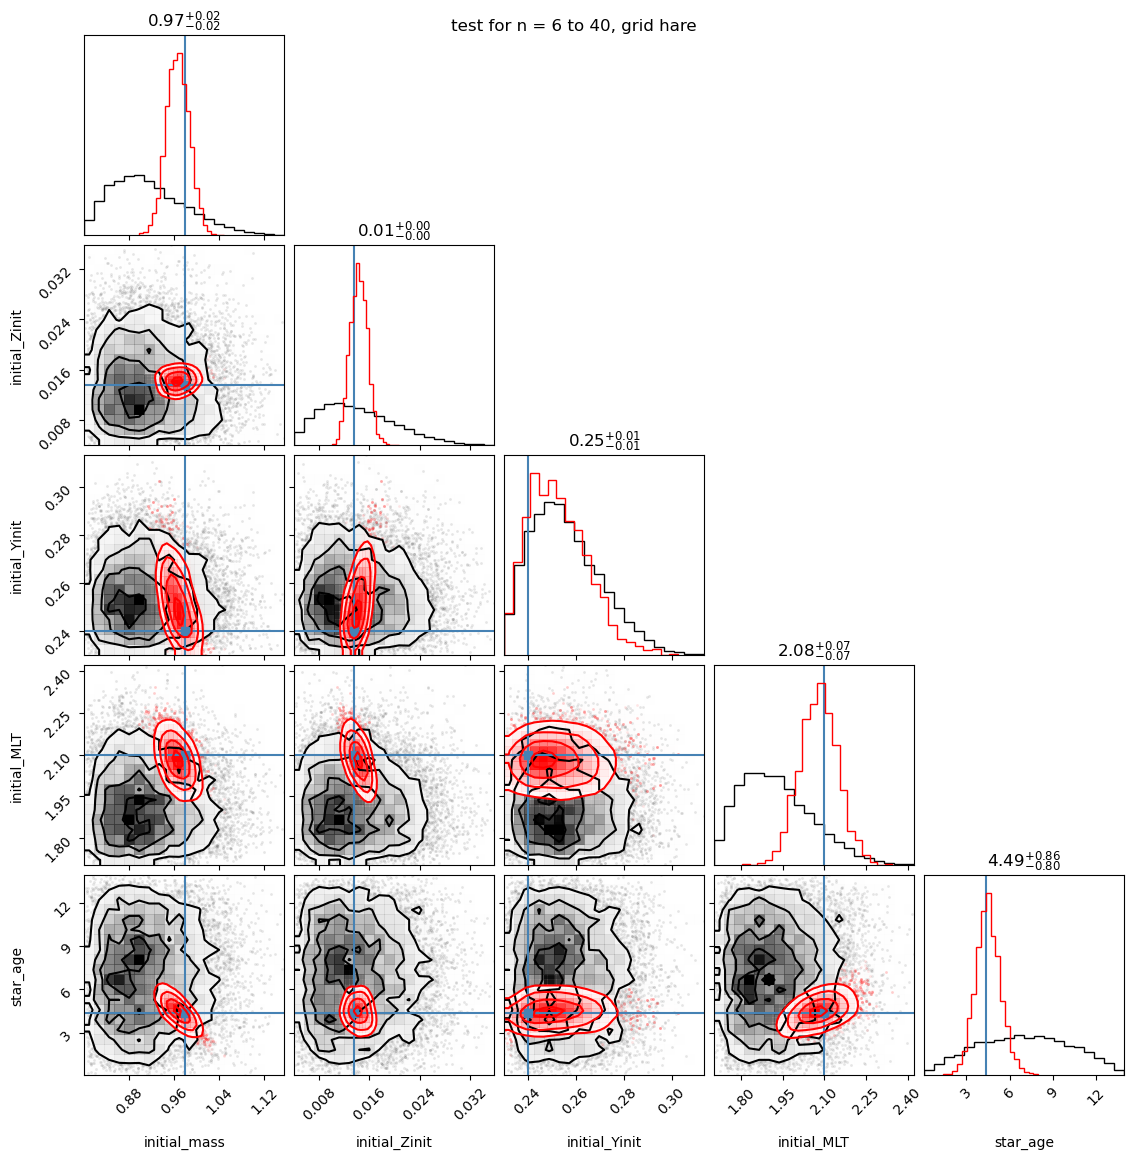

In [11]:
figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});
corner.corner(results['samples'], fig=figure, color='red',hist_kwargs={'density':True}, smooth=True,show_titles=True);
plt.suptitle('test for n = 6 to 40, grid hare')

In [13]:
sampler.plot_trace()

AttributeError: 'ultra_ns_vector_nice' object has no attribute 'plot_trace'

In [ ]:
hare = pd.read_json("pickle jar/solar_hare.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

n_min = 15
n_max = 25

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = pitchfork.predict([hare_inps.values[0]], n_min=n_min, n_max=n_max)

teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = .1 #\muHz


obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc for i in range(n_min,n_max+1)])

emulator_errors = pd.read_json('pickle jar/emulator_errors2.json')
emulator_errors.columns = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(6,41)]
emulator_errors = emulator_errors[outputs]

corr = np.corrcoef(emulator_errors.to_numpy().T)
plt.matshow(corr)

emulator_cov = np.cov(emulator_errors.to_numpy().T)

sigma_nn = emulator_cov

sigma_obs = (obs_unc*obs_unc)*(np.identity(len(emulator_cov)))

sigma = sigma_nn + sigma_obs

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)